In [27]:
%matplotlib inline 
import numpy as np
import pandas as pd

import statsmodels.api as sm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [28]:
df = pd.read_csv('data/listing_cleansed.csv')

### Filter on listings with high reviews number

In [29]:
df = df[~df.last_review.isnull()]
df = df[~df.review_scores_value.isnull()]
df = df[df.number_of_reviews>10]
#df = df[df.host_listings_count>1]

### Fill the missing data

In [30]:
columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

In [31]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent


### R-like str function

In [32]:
def get_unique(x):    
    return type(x.values[1]),x.unique()

def rstr(df):
    return df.apply(get_unique)

## Correlation with target

In [33]:
TARGET = 'availability_90'

In [34]:
df_corr = df.corr()[TARGET]
df_corr = pd.DataFrame(df_corr)
df_corr['corr_abs'] = np.abs(df_corr[TARGET])
df_corr = df_corr.sort_values(by='corr_abs',ascending=False)
df_corr.head(30)

,availability_90,corr_abs
availability_90,1.000000,1.000000
availability_60,0.952902,0.952902
availability_30,0.815027,0.815027
availability_365,0.555810,0.555810
review_scores_value,-0.211218,0.211218
price,0.198351,0.198351
last_review,-0.192065,0.192065
extra_people,0.188822,0.188822
review_scores_rating,-0.154430,0.154430
first_review,-0.124685,0.124685


In [35]:
top_ten_corr = df_corr.head(5).index.values
print top_ten_corr

['availability_90' 'availability_60' 'availability_30' 'availability_365'
 'review_scores_value']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc88823aa10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc87bb0cd50>]], dtype=object)

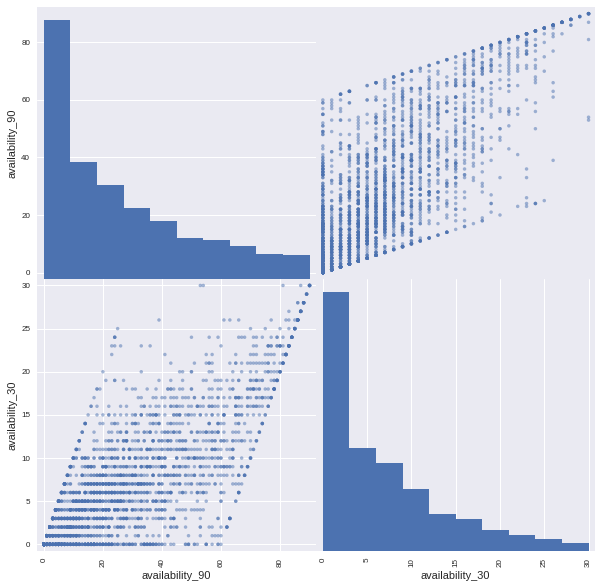

In [36]:
pd.plotting.scatter_matrix(df[[TARGET,'availability_30']], figsize=(10, 10))        

## Linear Model and R-squared

In [37]:
y = df.availability_90
X_columns = df_corr.index.values
X_columns = list(set(X_columns)-set(['availability_90','availability_30','availability_60','availability_365']))

In [38]:
X = df[X_columns]

In [39]:
X.shape

(3132, 196)

In [40]:
y.shape

(3132,)

In [41]:
mod =sm.OLS(y,sm.add_constant(X))

In [42]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        availability_90   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     5.699
Date:                Fri, 14 Jul 2017   Prob (F-statistic):           8.70e-94
Time:                        11:39:29   Log-Likelihood:                -13997.
No. Observations:                3132   AIC:                         2.834e+04
Df Residuals:                    2959   BIC:                         2.939e+04
Df Model:                         172                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                 -2926.2457   1197.600     -2.443      0.015   -5274.460    -578.032
amenities__Firmmatress                                    3.0854     31.703      0.097      0.922     -59.077      65.248
reviews_per_month                                         1.2702      0.553      2.298      0.022       0.187       2.354
neighbourhood_group_cleansed__Neuklln                  -248.2426     99.026     -2.507      0.012    -442.410     -54.075
property_type__Guesthouse                              2.493e-06   1.02e-06      2.442      0.015    4.91e-07    4.49e-06
amenities__Dishesandsilverware                           11.5896     94.408      0.123      0.902    -173.522     196.701
amenities__WasherDryer                                    4.6311      9.965      0.465      0.642     -14.907      24.169
neighbourhood_group_cleansed__Mitte                    -251.6918    100.491     -2.505      0.012    -448.731     -54.653
require_guest_profile_picture                             1.7762      3.670      0.484      0.628      -5.420       8.972
amenities__Internet                                      -0.8247      1.133     -0.728      0.467      -3.047       1.398
review_scores_cleanliness                                 1.6479      0.801      2.057      0.040       0.077       3.219
amenities__Stairgates                                   -23.9759     14.391     -1.666      0.096     -52.193       4.241
amenities__Accessibleheightbed                           -3.2721     46.094     -0.071      0.943     -93.652      87.108
neighbourhood_group_cleansed__Lichtenberg              -247.3378    100.422     -2.463      0.014    -444.241     -50.434
neighbourhood_group_cleansed__FriedrichshainKreuzberg  -250.5200     99.844     -2.509      0.012    -446.290     -54.750
amenities__Petsallowed                                    0.8664      1.196      0.724      0.469      -1.479       3.211
host_since                                               -0.0002      0.001     -0.194      0.846      -0.002       0.002
bed_type_RealBed                                       -579.2661    239.688     -2.417      0.016   -1049.238    -109.294
amenities__Accessibleheighttoilet                      5.869e-10    2.4e-10      2.444      0.015    1.16e-10    1.06e-09
neighbourhood_group_cleansed__Reinickendorf            -243.1574    102.305     -2.377      0.018    -443.754     -42.560
latitude                                                 75.4409     30.783      2.451      0.014      15.082     135.800
review_scores_checkin                                     1.2139      1.097      1.106      0.269      -0.938       3.365
host_verification_manual_online  

In [43]:
y.shape

(3132,)

### Train test split

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

### Linear Regression

In [45]:
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
r2_score(y_test.values,prediction)

-23737641.719531983

In [46]:
df_prediction = pd.DataFrame({'observed':y_test,'predicted':prediction})

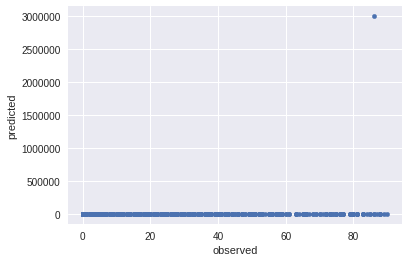

In [47]:
df_prediction.plot.scatter(x='observed',y='predicted')

### Random Forest

In [48]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
r2_score(y_test.values,prediction)

0.21453708136021765

### XGB

In [49]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
prediction = xgb.predict(X_test)
r2_score(y_test.values,prediction)

0.29849019236510055